In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("..")

from cybb_mist.path_conf import interim_data_dir, processed_data_dir
from tqdm.auto import tqdm
import pandas as pd
from functional import seq
from cybb_mist.trigger_mapping import parse_trigger_series


## joining `df_trigger_tot` with `df_rr`

In [3]:
import hrvanalysis

In [17]:
r_list = []
for pqt in tqdm(sorted(list(interim_data_dir.rglob("*/SCL_*.parquet")))):
    try:
        patient_id = pqt.parent.name
        condition = pqt.name.split(".")[0].split("_")[-1]
        df_trigger = parse_trigger_series(pd.read_parquet(pqt)["trigger"])
        df_trigger["patient_id"] = patient_id
        df_trigger["condition"] = condition
        df_trigger["duration"] = df_trigger["t_end"] - df_trigger["t_start"]
        df_trigger["duration_s"] = df_trigger["duration"].dt.total_seconds()
        df_trigger = df_trigger.dropna().drop_duplicates(
            subset=["trigger"], keep="first"
        )

        p = list(processed_data_dir.joinpath(patient_id).glob(f"df_rr_{condition}.parquet"))
        if not len(p):
            print(f"skipping user: {patient_id} - no df_rr")
            continue
        df_rr = pd.read_parquet(p[0])

        min_r_peak_agreement_threshold = 0.8

        for _, r in df_trigger.iterrows():
            if r.duration_s + 10 < 300:
                print(
                    f"skipping slice:{r.patient_id} - {r.trigger} - duration ({r.duration}) too short"
                )
                continue

            # slc = df_rr[r.t_start : r.t_start + pd.Timedelta(minutes=5)]
            slc = df_rr[r.t_end - pd.Timedelta(minutes=5) : r.t_end]
            # do not use slices with lower
            mean_r_peak_agreement = slc["r_peak_agreement"].mean()

            rrs = hrvanalysis.remove_outliers(
                slc["RR_interval_ms"].dropna().values, verbose=False
            )

            if (
                mean_r_peak_agreement < min_r_peak_agreement_threshold
            ) or len(rrs) < 250:
                print(len(slc), len(slc.RR_interval_ms.dropna()), len(rrs))
                print(
                    f"skipping slice user - {r.patient_id} - {r.trigger} - "
                    "{len(slc)} - {mean_r_peak_agreement}"
                )
                continue

            r_list.append(
                pd.concat(
                    [
                        r,
                        pd.Series(hrvanalysis.get_time_domain_features(rrs)),
                        pd.Series(hrvanalysis.get_frequency_domain_features(rrs)),
                    ]
                )
            )

    except Exception as e:
        print(e)


  0%|          | 0/124 [00:00<?, ?it/s]

skipping user: 14 - no df_rr
0 0 0
skipping slice user - 16 - Start rest control (eyes open) - {len(slc)} - {mean_r_peak_agreement}
337 183 183
skipping slice user - 28 - Start rest baseline (eyes closed) - {len(slc)} - {mean_r_peak_agreement}
262 0 0
skipping slice user - 31 - Start rest baseline (eyes open) - {len(slc)} - {mean_r_peak_agreement}
172 0 0
skipping slice user - 31 - Start cyberball control - {len(slc)} - {mean_r_peak_agreement}
175 0 0
skipping slice user - 31 - Start rest control (eyes closed) - {len(slc)} - {mean_r_peak_agreement}
191 0 0
skipping slice user - 31 - Start rest control (eyes open) - {len(slc)} - {mean_r_peak_agreement}
136 0 0
skipping slice user - 31 - Start cyberball stress - {len(slc)} - {mean_r_peak_agreement}
0 0 0
skipping slice user - 31 - Start rest stress (eyes closed) - {len(slc)} - {mean_r_peak_agreement}
0 0 0
skipping slice user - 31 - Start rest stress (eyes open) - {len(slc)} - {mean_r_peak_agreement}
208 0 0
skipping slice user - 37 - St

In [18]:
df_feat = pd.concat(r_list, axis=1).T

In [20]:
scl_list = []
for pqt in tqdm(sorted(list(interim_data_dir.rglob("*/SCL_*.parquet")))):
    try:
        patient_id = pqt.parent.name
        condition = pqt.name.split(".")[0].split("_")[-1]
        df_trigger = parse_trigger_series(pd.read_parquet(pqt)["trigger"])
        df_trigger["patient_id"] = patient_id
        df_trigger["condition"] = condition
        df_trigger["duration"] = df_trigger["t_end"] - df_trigger["t_start"]
        df_trigger["duration_s"] = df_trigger["duration"].dt.total_seconds()
        df_trigger = df_trigger.dropna().drop_duplicates(
            subset=["trigger"], keep="first"
        )

        p = list(
            processed_data_dir.joinpath(patient_id).glob(
                f"df_scl_proc_{condition}.parquet"
            )
        )
        if not len(p):
            print(f"skipping user: {patient_id} - no df_scl")
            continue
        df_scl = pd.read_parquet(p[0])

        min_SQI_threshold = 0.9

        for _, r in df_trigger.iterrows():
            if r.duration_s + 10 < 300:
                print(
                    f"skipping slice:{r.patient_id} - {r.trigger} - duration ({r.duration}) too short"
                )
                continue

            slc = df_scl[r.t_end - pd.Timedelta(minutes=5) : r.t_end]
            # do not use slices with lower
            mean_sqi = slc["EDA_SQI_smoothend"].mean()

            if mean_sqi < min_SQI_threshold:  # or len(rrs) < 300:
                # print(len(slc), len(slc.RR_interval_ms.dropna()), len(rrs))
                print(
                    f"skipping slice user - {r.patient_id} - {r.trigger} - "
                    f"{mean_sqi} - {min_SQI_threshold}"
                )
                continue

            scl_list.append(
                pd.concat(
                    [
                        r,
                        pd.Series(
                            {
                                # skin conductance responses per minute
                                "SCRR": slc["SCR_Peaks_scipy_reduced"].fillna(0).sum()
                                / 5,
                                "phasic_area": slc["EDA_Phasic"].mean(),
                                "tonic_mean": slc["EDA_lf_cleaned_tonic_lf"].mean(),
                                "phasic_area_normalized": slc[
                                    "EDA_lf_cleaned_tonic_lf"
                                ].mean(),
                                "mean_EDA_SQI": slc["EDA_SQI_smoothend"].mean(),
                            }
                        ),
                    ]
                )
            )

    except Exception as e:
        print(e)

    # break


  0%|          | 0/124 [00:00<?, ?it/s]

skipping user: 14 - no df_scl
skipping slice user - 16 - Start rest control (eyes open) - 0.0 - 0.9
skipping slice user - 34 - Start rest stress (eyes open) - 0.8983672109296901 - 0.9
skipping user: 41 - no df_scl


In [29]:
df_trigger.columns

Index(['t_start', 'trigger', 't_end', 'patient_id', 'condition', 'duration',
       'duration_s'],
      dtype='object')

In [28]:
df_feat.columns

Index(['t_start', 'trigger', 't_end', 'patient_id', 'condition', 'duration',
       'duration_s', 'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20',
       'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni',
       'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio',
       'lfnu', 'hfnu', 'total_power', 'vlf'],
      dtype='object')

In [33]:
merge_cols = ["patient_id", "trigger", "condition"]
df_feat_tot = df_feat.merge(
    pd.concat(scl_list, axis=1).T.drop(
        columns=set(df_trigger.columns).difference(
            ["patient_id", "trigger", "condition"]
        )
    ),
    on=["patient_id", "trigger", "condition"],
    how="outer",
)


## Analyzing `df_feat`

In [34]:
import seaborn as sns

sns.set_context("talk")


In [35]:
df_feat_tot.melt(
        id_vars=[
            "t_start",
            "t_end",
            "patient_id",
            "condition",
            "trigger",
            "duration",
            "duration_s",
        ]
    ).variable.value_counts()

mean_nni                  969
sdnn                      969
phasic_area_normalized    969
tonic_mean                969
phasic_area               969
SCRR                      969
vlf                       969
total_power               969
hfnu                      969
lfnu                      969
lf_hf_ratio               969
hf                        969
lf                        969
std_hr                    969
min_hr                    969
max_hr                    969
mean_hr                   969
cvnni                     969
cvsd                      969
range_nni                 969
median_nni                969
rmssd                     969
pnni_20                   969
nni_20                    969
pnni_50                   969
nni_50                    969
sdsd                      969
mean_EDA_SQI              969
Name: variable, dtype: int64

In [36]:
df_feat.trigger.value_counts()

Start rest baseline (eyes open)      114
Start rest control (eyes closed)     114
Start rest baseline (eyes closed)    112
Start rest control (eyes open)       112
Start rest stress (eyes closed)      111
Start rest stress (eyes open)        109
Start cyberball control               59
Start cyberball stress                58
Start MIST control                    56
Start MIST stress                     53
Name: trigger, dtype: int64

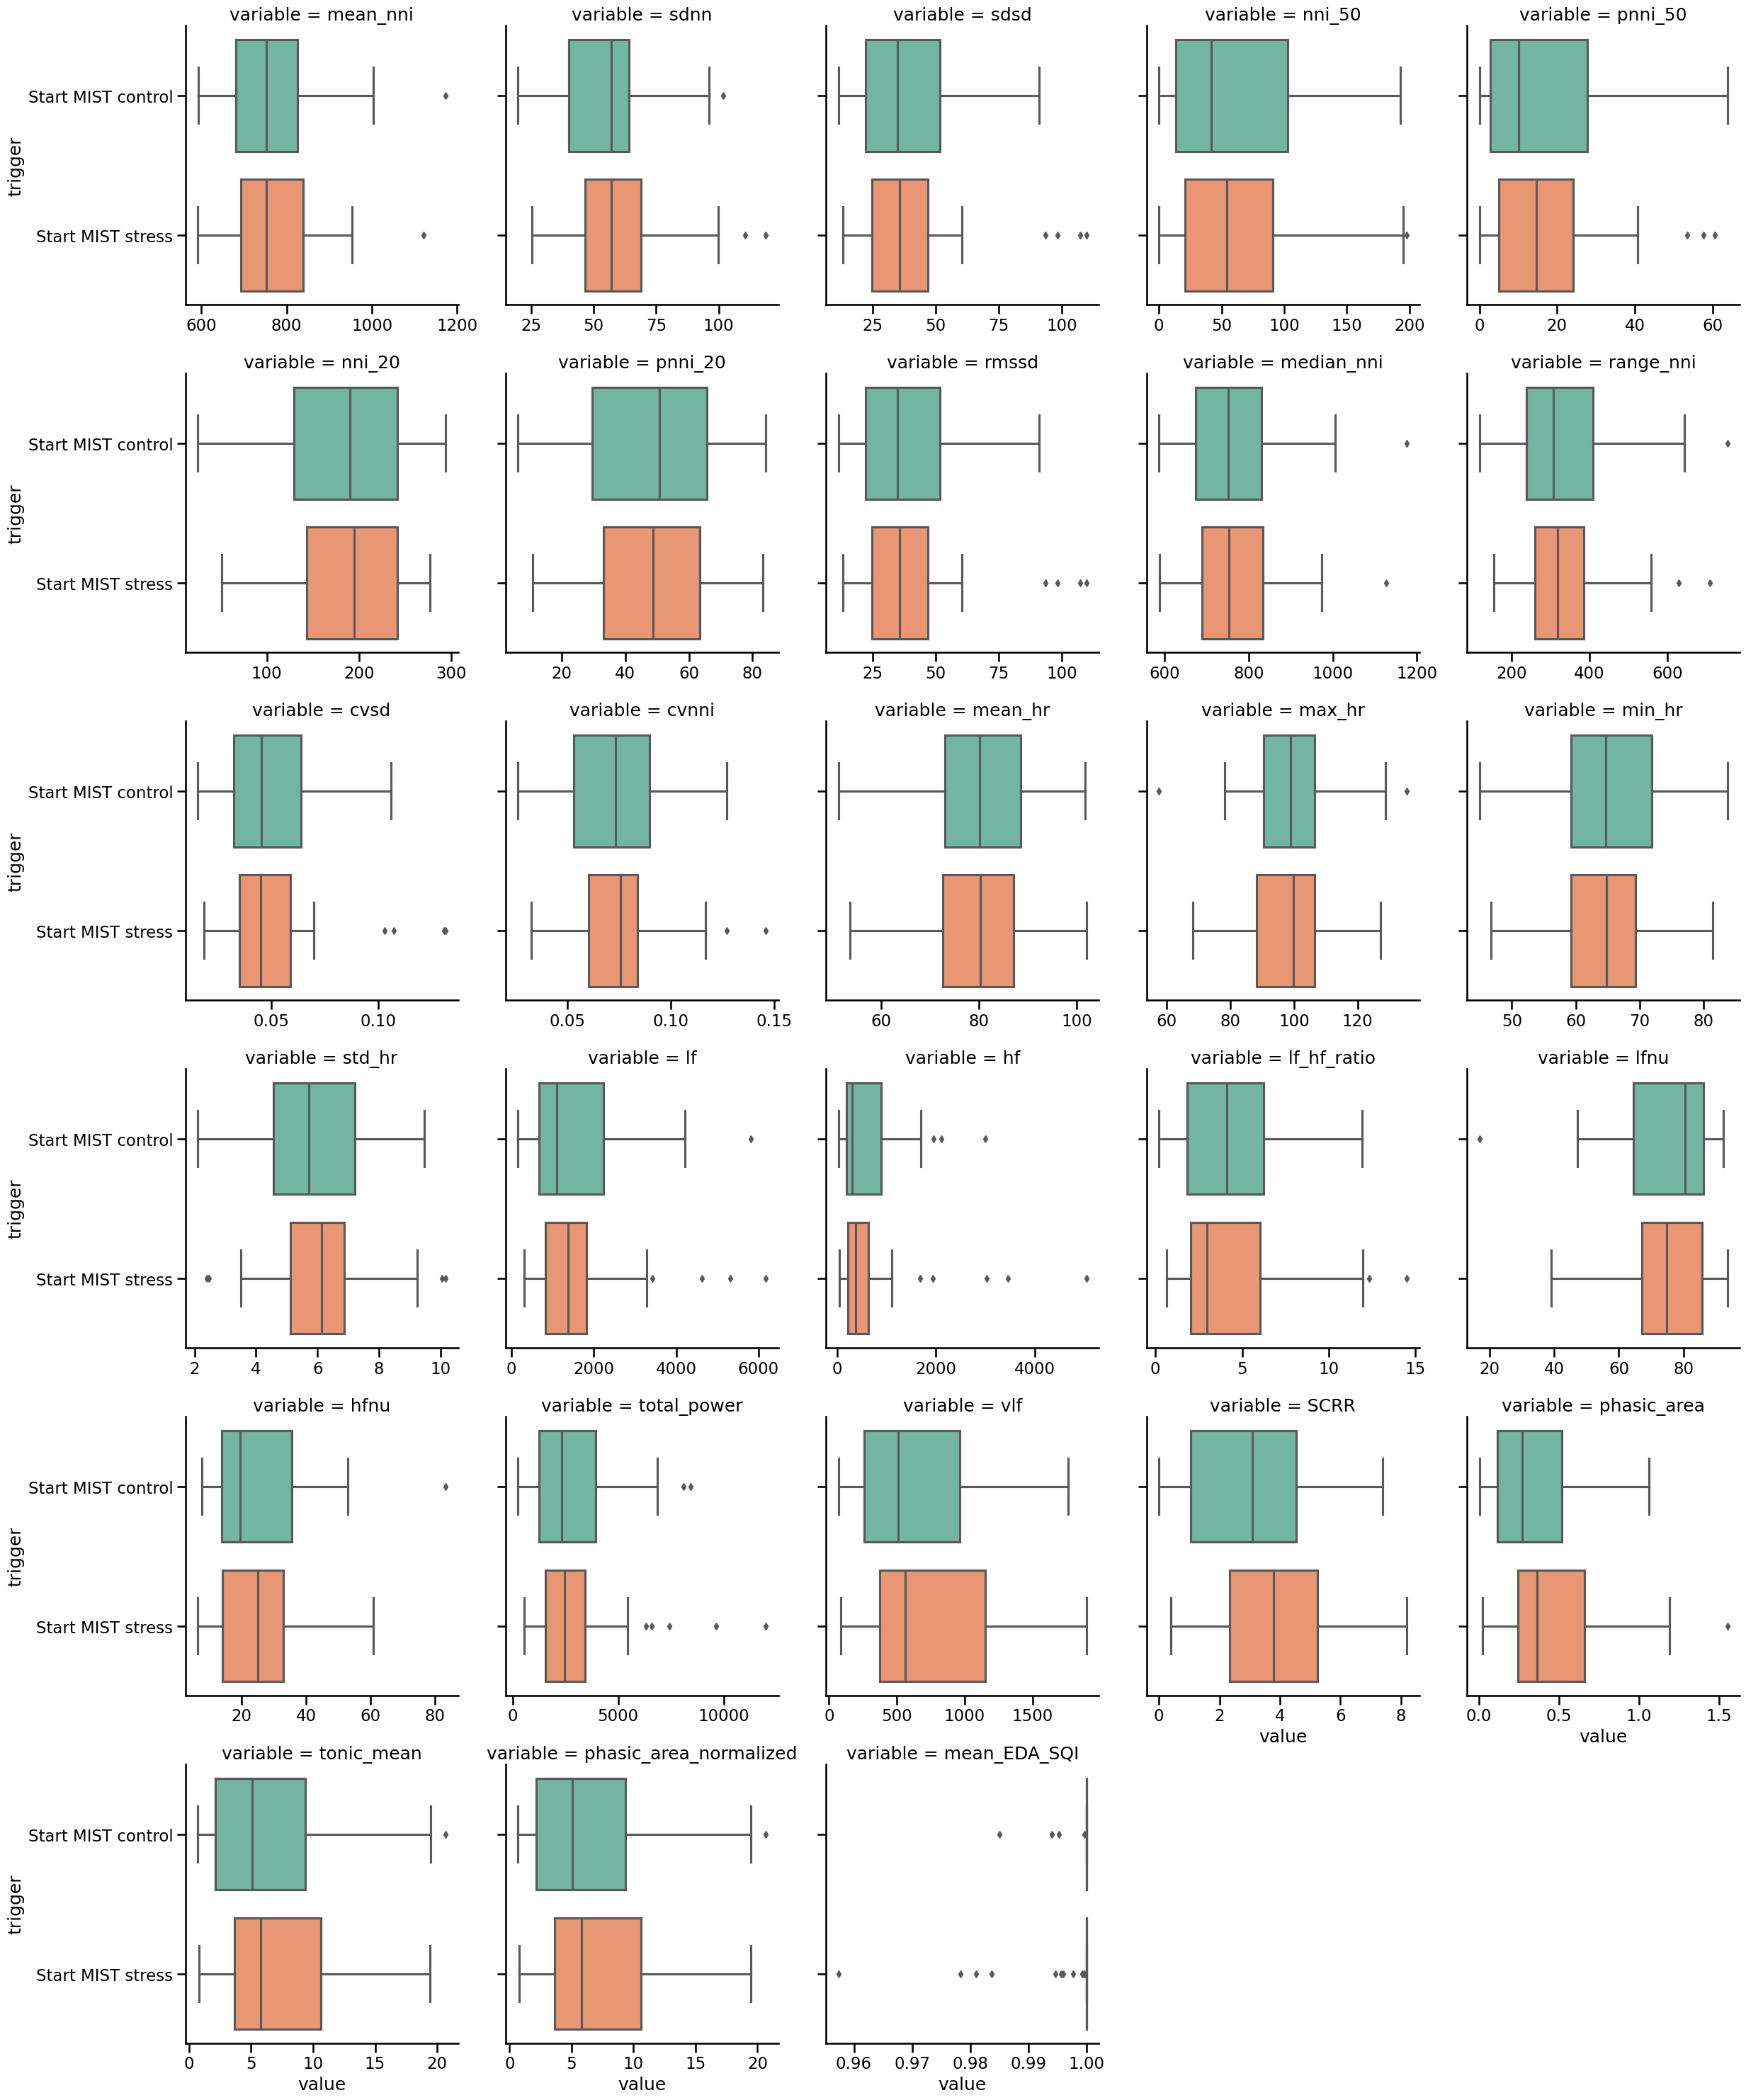

In [38]:
sns.catplot(
    data=df_feat_tot[
        df_feat_tot.trigger.isin(["Start MIST control", "Start MIST stress"])
    ].melt(
        id_vars=[
            "t_start",
            "t_end",
            "patient_id",
            "condition",
            "trigger",
            "duration",
            "duration_s",
        ]
    ),
    kind="box",
    x="value",
    y="trigger",
    aspect=1,
    col="variable",
    col_wrap=5,
    palette="Set2",
    sharex=False,
)


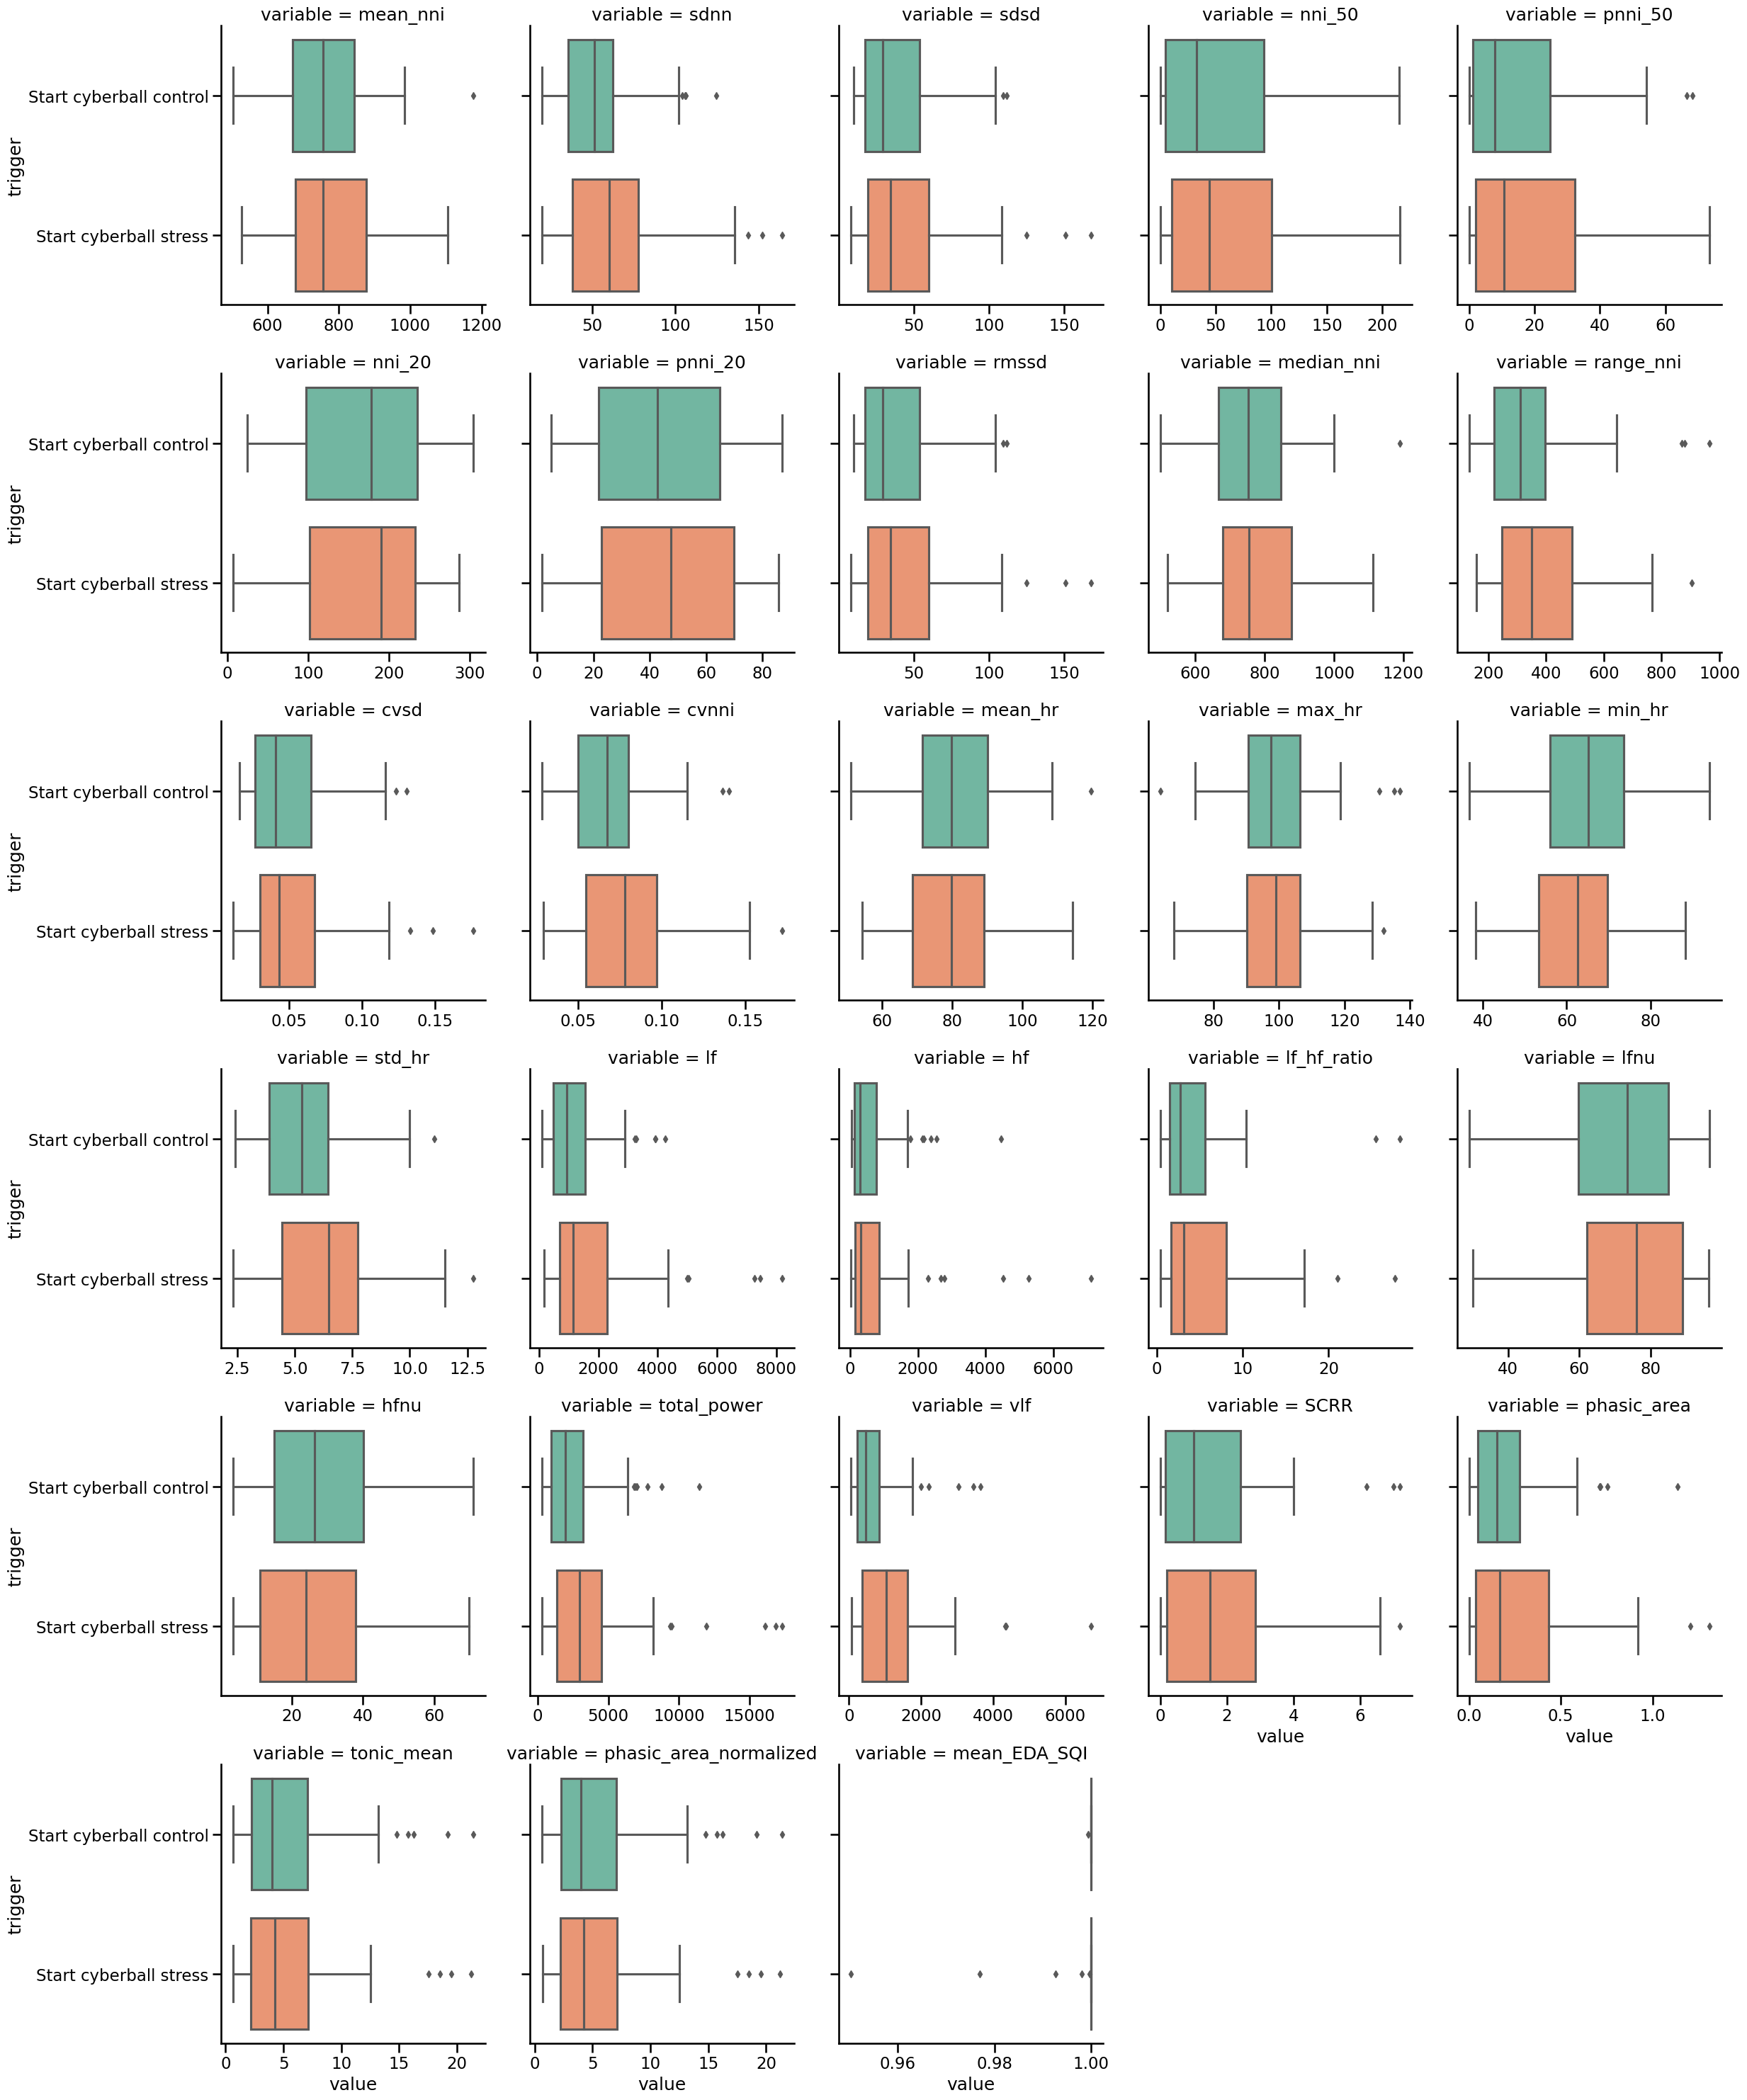

In [39]:
sns.catplot(
    data=df_feat_tot[
        df_feat_tot.trigger.isin(["Start cyberball control", "Start cyberball stress"])
    ].melt(
        id_vars=[
            "t_start",
            "t_end",
            "patient_id",
            "condition",
            "trigger",
            "duration",
            "duration_s",
        ]
    ),
    kind="box",
    x="value",
    y="trigger",
    aspect=1,
    col="variable",
    col_wrap=5,
    palette="Set2",
    sharex=False,
)


In [40]:
df_feat.drop(columns=['duration']).to_parquet('df_feat_tot.parquet')